# Numeric evaluation of deep chroma estimator

Johannes Zeitler (johannes.zeitler@audiolabs-erlangen.de), 2023

Code base for ISMIR 2023 paper 

In [1]:
import os
import sys

In [2]:
# make only GPU 0 visible
os.environ['CUDA_VISIBLE_DEVICES']='0'

#device_train = 'cpu'
device_train = 'cuda:0'

#device_test = 'cpu'
device_test = 'cuda:0'

In [ ]:
import libfmp.b
import libfmp.c3
import libfmp.c4
import libfmp.c5
import librosa
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
from time import time, gmtime, strftime
import torch 
import torch.nn.functional as F

from libdl.nn_models import *
from libdl.data_loaders.parallelDataset import ParallelHCQTLoader 
from libdl.metrics import early_stopping
from libdl.training import Trainer
from libdl.data_loaders.parallelDataset import ParallelHCQTLoader 
from libdl.nn_losses.soft_dtw_cuda import SoftDTW


from torchinfo import summary
import h5py
from scipy.signal import convolve2d

In [4]:
batch_size = 32
num_targets = 500

# Set model parameters
n_chan_input=5               # C
n_chan_layers=[20,20,10,1]   # N0, N1, N2, N3
n_bins_in=216                # P * B = 72 * 3
n_bins_out=12                # chromas
a_lrelu=0.3
p_dropout=0.0

In [5]:
checkpoint_dir = os.path.join("../", "Models", "Final",)

model_name = "Chroma_Estimation_baseline_strong_run0.pt"

model = basic_cnn_segm_sigmoid(n_chan_input, n_chan_layers, n_bins_in, n_bins_out, a_lrelu, p_dropout)
model.load_state_dict(torch.load(os.path.join(checkpoint_dir, model_name)))

model.to(device_test)
model.eval()

basic_cnn_segm_sigmoid(
  (layernorm): LayerNorm((5, 216), eps=1e-05, elementwise_affine=True)
  (conv1): Sequential(
    (0): Conv2d(5, 20, kernel_size=(15, 15), stride=(1, 1), padding=(7, 7))
    (1): LeakyReLU(negative_slope=0.3)
    (2): MaxPool2d(kernel_size=(3, 1), stride=(1, 1), padding=(1, 0), dilation=1, ceil_mode=False)
    (3): Dropout(p=0.0, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 3), padding=(1, 0))
    (1): LeakyReLU(negative_slope=0.3)
    (2): MaxPool2d(kernel_size=(13, 1), stride=(1, 1), padding=(6, 0), dilation=1, ceil_mode=False)
    (3): Dropout(p=0.0, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv2d(20, 10, kernel_size=(75, 1), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.3)
    (2): Dropout(p=0.0, inplace=False)
  )
  (conv4): Sequential(
    (0): Conv2d(10, 1, kernel_size=(1, 1), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.3)
    (2): Dropout(p=0.0, inplace=False)
    (3): Conv2d(1, 1,

In [6]:
data_path = "../Data/Schubert_Winterreise_hcqt"
test_versions = ['HU33', 'SC06']

fileList_test =  []

for f in os.listdir(data_path):
    if '.h5' in f:
        for version in test_versions:
            if version in f:
                fileList_test.append(os.path.join(data_path, f))
fileList_test.sort()


In [7]:
test_loader = ParallelHCQTLoader(fileList=fileList_test,
          stride=100, # choose always the same segments from each file with a shift of 100
          max_workers=8, 
          batch_size=batch_size,
          numContextFrames=num_targets+74,
          verbose=False,
          shuffle=False,
          jointContextLoading=False,
          data_label="hcqt",
          target_label="chroma",
          cycle=False,
          num_targets=num_targets,
          weak_labels=True,
          expand_weak_labels=False)

test_loader_strong = ParallelHCQTLoader(fileList=fileList_test,
          stride=100, # choose always the same segments from each file with a shift of 100
          max_workers=8, 
          batch_size=batch_size,
          numContextFrames=num_targets+74,
          verbose=False,
          shuffle=False,
          jointContextLoading=False,
          data_label="hcqt",
          target_label="chroma",
          cycle=False,
          num_targets=num_targets,
          weak_labels=False,
          expand_weak_labels=False)

In [8]:
all_labels = []
all_preds = []
model.eval()
model.to(device_test)
with torch.no_grad():
    for i, (x, y) in enumerate(test_loader_strong):
        x = x.to(device_test)
        all_labels.append(y)
        all_preds.append(model(x))

lastIdx = len(all_labels)
if all_labels[-1].shape[0] != all_labels[0].shape[0]:
    lastIdx -= 1

all_labels_concat = torch.stack(all_labels[:lastIdx]).cpu().numpy()
all_preds_concat = torch.stack(all_preds[:lastIdx]).cpu().numpy()

In [9]:
prec, rec, fmeas, _, _, _ = libfmp.c5.compute_eval_measures(all_labels_concat, all_preds_concat>.5)

print(f'{"Precision:" : <15}{prec : .3f}')
print(f'{"Recall:" : <15}{rec : .3f}')
print(f'{"F-measure:" : <15}{fmeas : .3f}')

Precision:      0.840
Recall:         0.870
F-measure:      0.855


Text(0, 0.5, 'Pitch class')

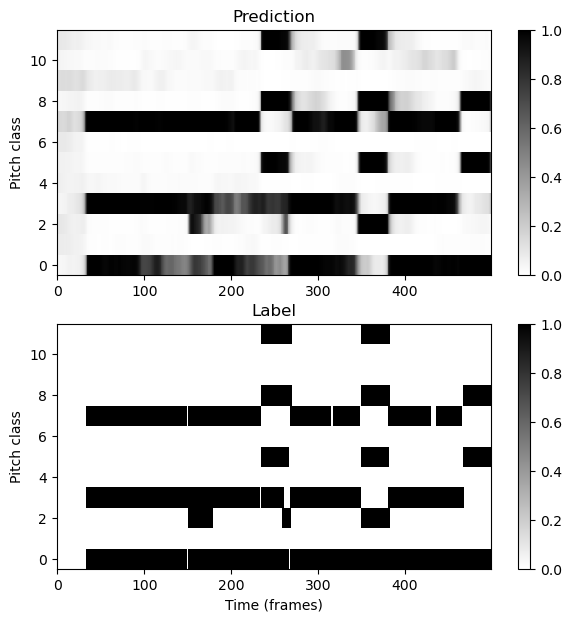

In [10]:
fig, ax = plt.subplots(2, 1, figsize=(7,7))

im0 = ax[0].imshow(all_preds_concat[0,0,0].T, origin='lower', cmap='gray_r', aspect='auto', interpolation="None", clim=[0,1])
im1 = ax[1].imshow(all_labels_concat[0,0,0].T, origin='lower', cmap='gray_r', aspect='auto', interpolation="None", clim=[0,1])

ax[0].set_title("Prediction")
ax[1].set_title("Label")

plt.colorbar(im0, ax=ax[0])
plt.colorbar(im1, ax=ax[1])

ax[1].set_xlabel("Time (frames)")
ax[0].set_ylabel("Pitch class")
ax[1].set_ylabel("Pitch class")